In [1]:
import diplib as dip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import string
from tqdm import trange

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


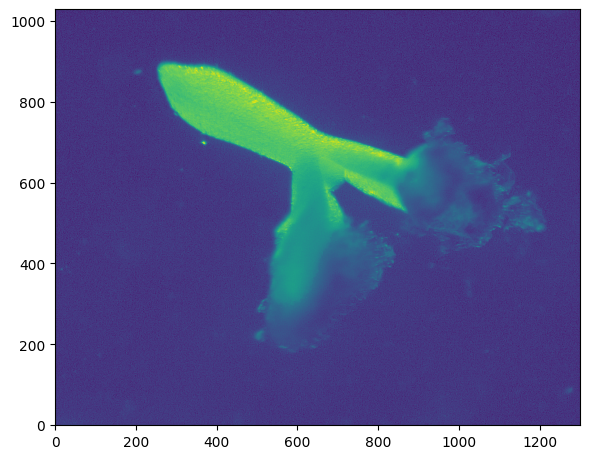

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))
img = dip.ImageReadTIFF('images/w8t1t2_d7_01.tif')
img = img / 2 ** 16
grey_img = dip.ColorSpaceManager.Convert(img, 'grey')
ax.imshow(grey_img, origin='lower')
plt.tight_layout()

# 5.1

In [136]:
def segment_embryo(img):
    grayscale = dip.ColorSpaceManager.Convert(img, 'grey')
    
    smoothed = dip.Gauss(grayscale, sigmas=[2.0])
    hist = dip.Histogram(smoothed)
    hist.Show()
    
    # thresholded = dip.IsodataThreshold(grayscale)
    thresh = 0.025
    thresholded = smoothed > thresh
    
    cleaned = dip.BinaryClosing(thresholded, iterations=3)
    cleaned = dip.BinaryOpening(cleaned, iterations=2)
        
    labeled = dip.Label(cleaned, connectivity=2)
    sizes = dip.MeasurementTool.Measure(labeled, features=['Size'])
    largest_label = np.argmax(sizes['Size']) + 1
    # print(sizes)
    mask = labeled == largest_label
    
    return mask

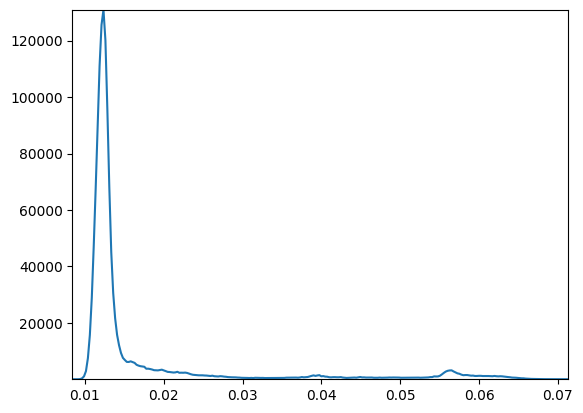

   |       Size | 
-- | ---------- | 
   |            | 
   |     (mm^2) | 
-- | ---------- | 
 1 |      17.71 | 
 2 |      9981. | 
 3 |      12.67 | 
 4 |      7.070 | 
 5 |      1.470 | 
 6 |      29.75 | 
 7 |      2.240 | 
 8 |      65.24 | 
 9 |      6.090 | 
10 |      8.541 | 
11 |      70.00 | 
12 |      4.480 | 
13 |      16.10 | 
14 |      1.820 | 
15 |      14.21 | 
16 |      2.100 | 
17 |      41.02 | 
18 |      11.06 | 
19 |      5.950 | 
20 |      1.470 | 



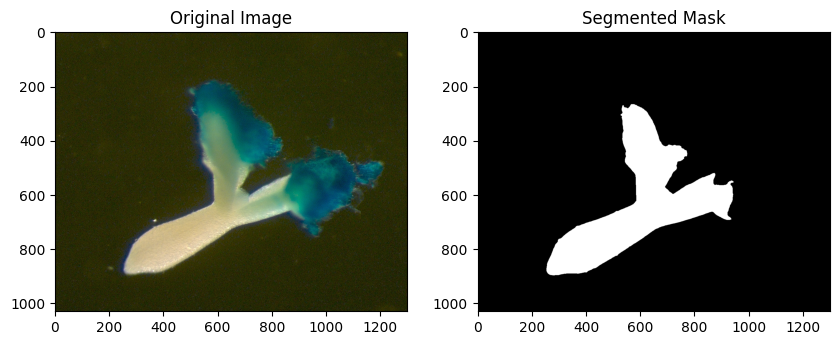

In [138]:
img = dip.ImageReadTIFF('images/w8t1t2_d7_01.tif')
img = img / 2 ** 16 
mask = segment_embryo(img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Segmented Mask')
plt.imshow(mask, cmap='gray')
plt.show()

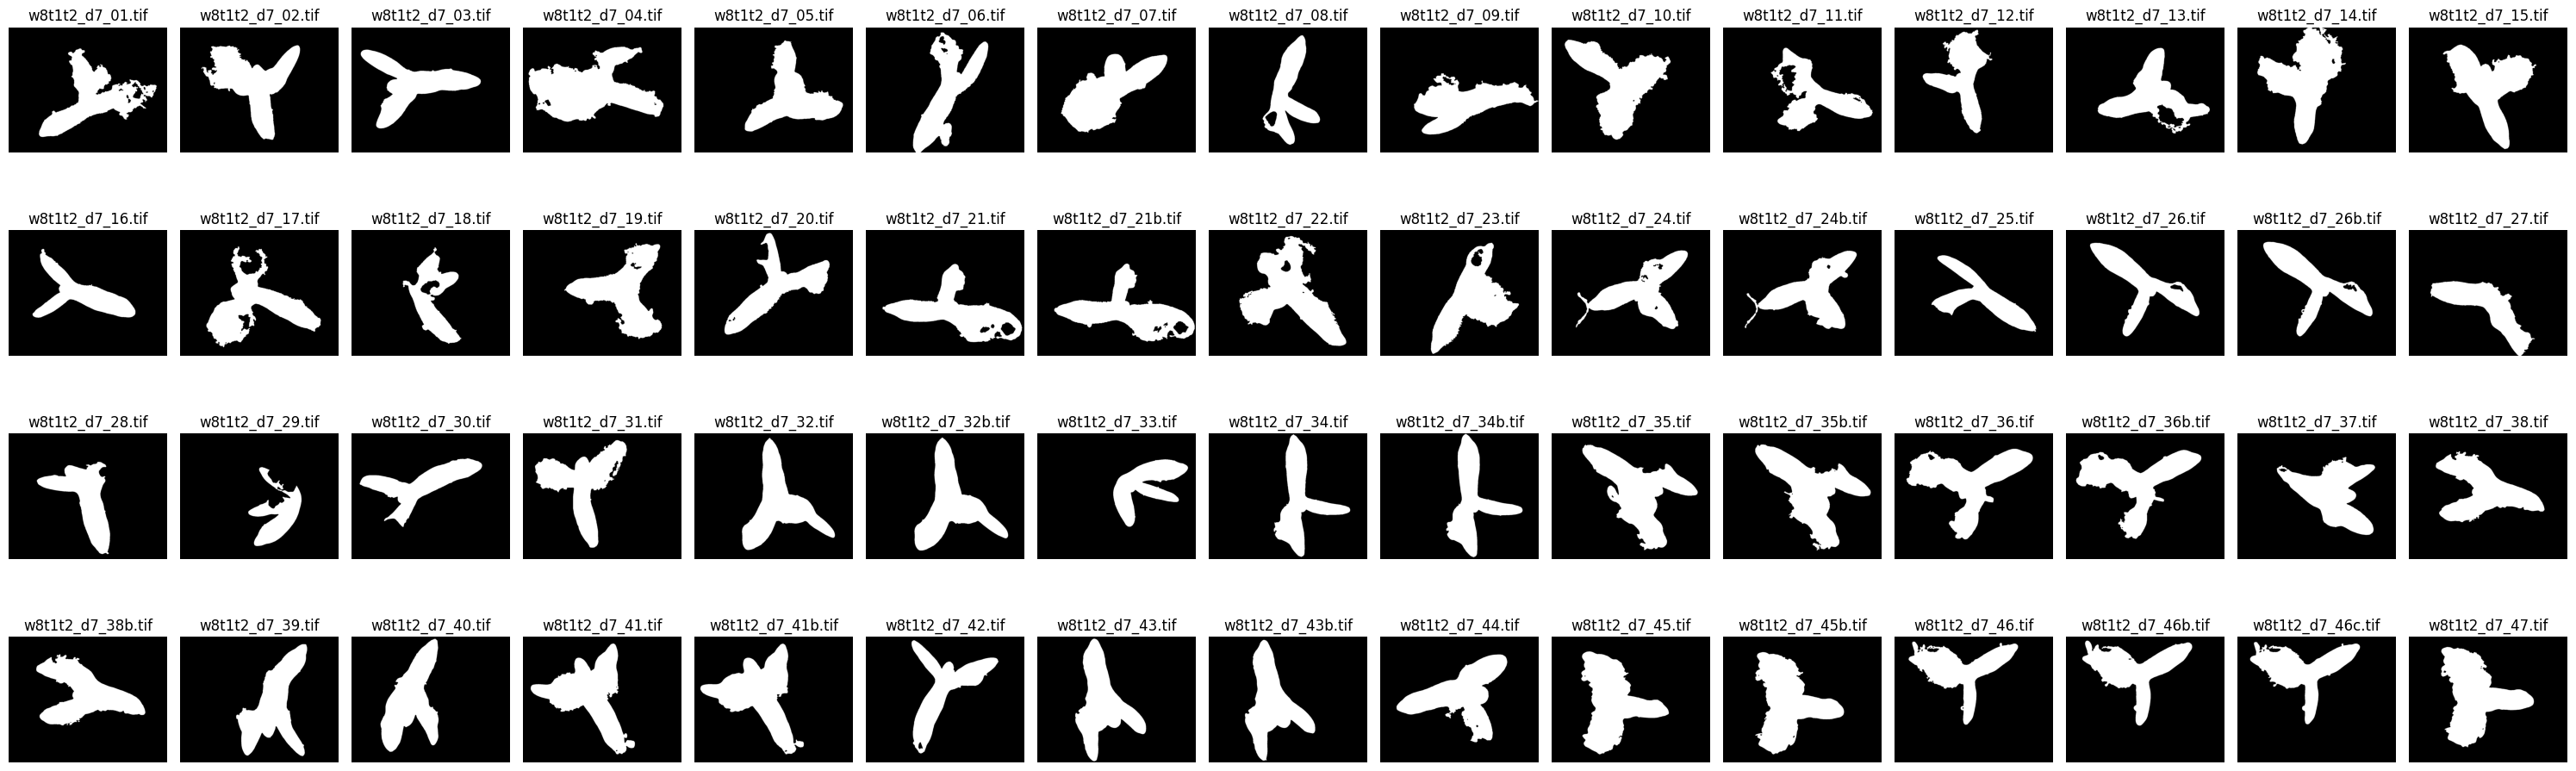

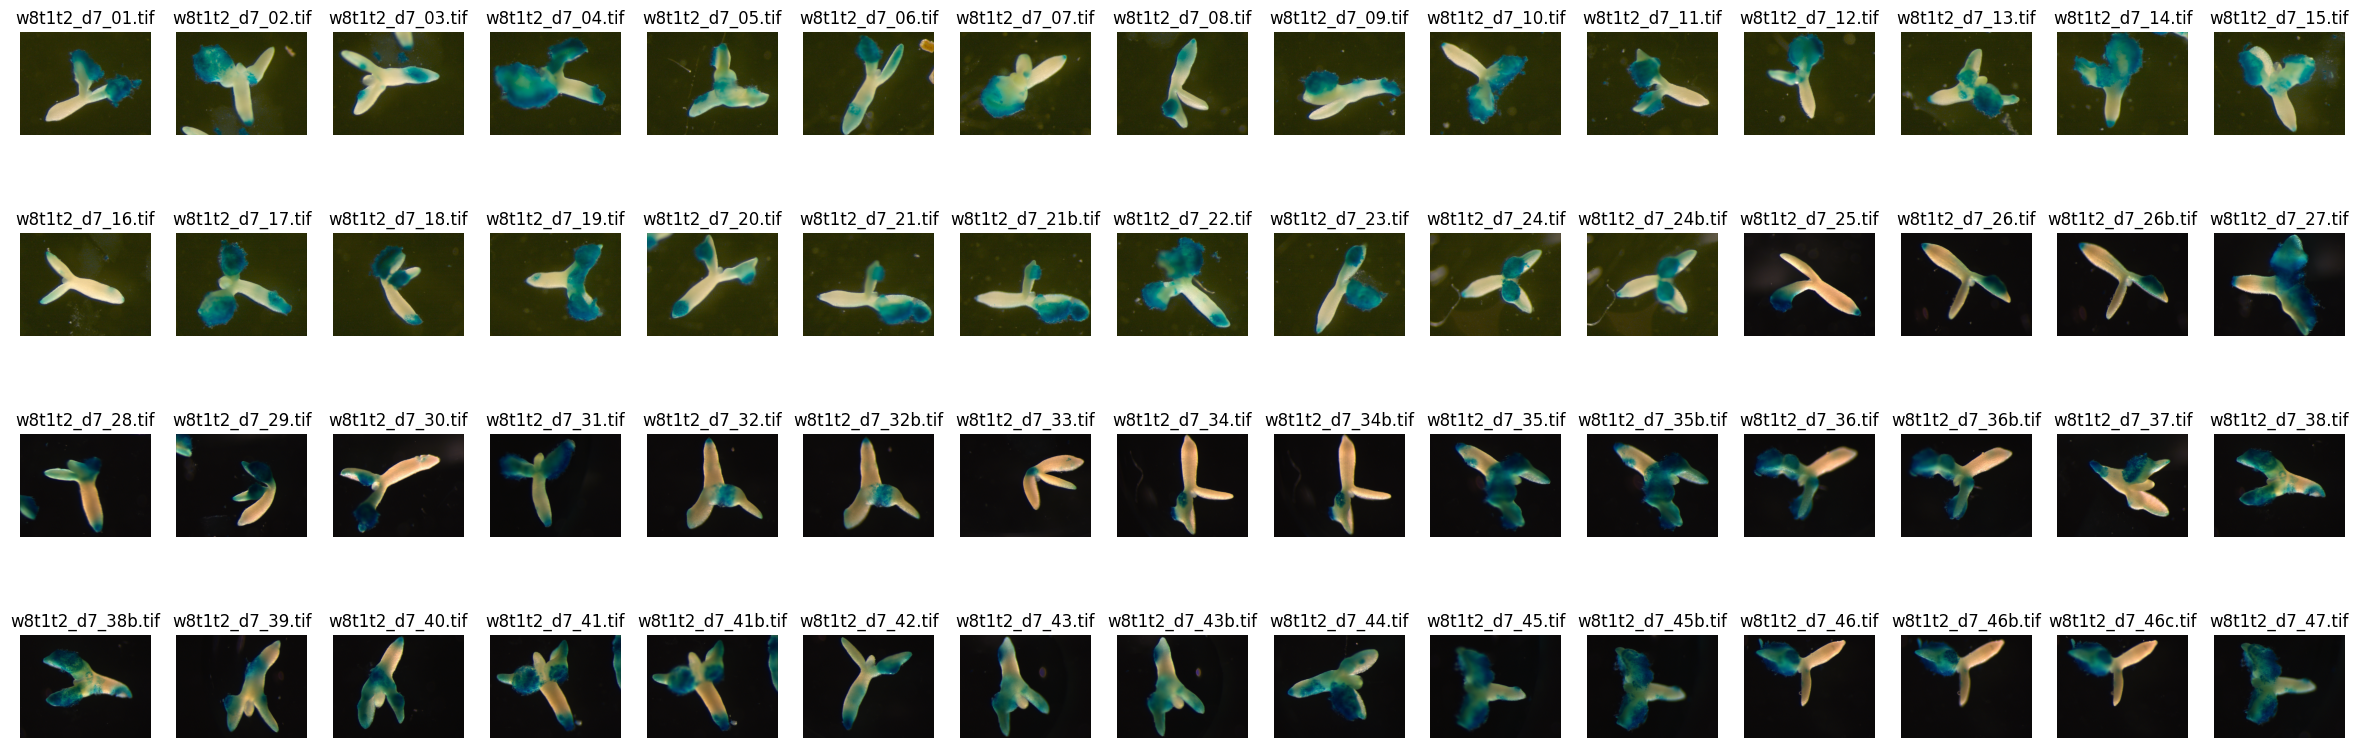

In [153]:
import os

def segment_embryo(img):
    grayscale = dip.ColorSpaceManager.Convert(img, 'grey')
    
    smoothed = dip.Gauss(grayscale, sigmas=[2.0])
    # hist = dip.Histogram(smoothed)
    # hist.Show()
    
    # thresh = 0.025
    # thresholded = smoothed > thresh
    # thresholded = dip.IsodataThreshold(smoothed)
    # thresholded = dip.OtsuThreshold(smoothed)
    thresholded = dip.TriangleThreshold (smoothed)
    
    cleaned = dip.BinaryClosing(thresholded, iterations=3)
    cleaned = dip.BinaryOpening(cleaned, iterations=2)
        
    labeled = dip.Label(cleaned, connectivity=2)
    sizes = dip.MeasurementTool.Measure(labeled, features=['Size'])
    largest_label = np.argmax(sizes['Size']) + 1
    mask = labeled == largest_label
    
    return mask

def process_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    processed_images = []
    
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = dip.ImageReadTIFF(img_path)
        img = img / 2 ** 16
        mask = segment_embryo(img)
        processed_images.append((img, mask, image_file))
        
    return processed_images

def create_image_panel(images, grid_size=(4, 15)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(30, 10))
    axes = axes.flatten()
    
    for ax, (img, mask, title) in zip(axes, images):
        ax.imshow(np.array(mask), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(30, 10))
    axes = axes.flatten()
    for ax, (img, mask, title) in zip(axes, images):
        ax.imshow(np.array(img), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        
image_dir = 'images/'
processed_images = process_images(image_dir)
create_image_panel(processed_images)